In [1]:
import os
# Select 2 available GPUs
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

import numpy as np
import joblib
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import gc

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import timm
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2

import ogb
from ogb.utils import smiles2graph
from ogb.lsc import PCQM4Mv2Dataset

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(torch.__version__)
print(timm.__version__)

seed_everything()

1.12.1+cu102
0.6.11


In [9]:
# Point to competition dataset directory
ROOT = '../dataset'
dataset = PCQM4Mv2Dataset(root = ROOT, only_smiles =True)

# Convert to Dataframe: smiles + target
train = pd.DataFrame({
    'smiles': [dataset[i][0] for i in range(len(dataset))],
    'target': [dataset[i][1] for i in range(len(dataset))]
})
train.to_parquet('train.parquet')

# Get competition splits
split_dict = dataset.get_idx_split()
train_idx = split_dict['train'] # numpy array storing indices of training molecules
valid_idx = split_dict['valid'] # numpy array storing indices of validation molecules
testdev_idx = split_dict['test-dev'] # numpy array storing indices of test-dev molecules
testchallenge_idx = split_dict['test-challenge'] # numpy array storing indices of test-challenge molecules

In [12]:
# Set the fold to be trained. Values ranges from 0 to 3
FOLD = 0 # 0, 1, 2, 3

#Point to development folds split file
splits = torch.load('../new_split_dict.pt')

# Load smiles dataframe
train = pd.read_parquet('train.parquet')

train['path'] = '../images/' + train['id'].map(str) + '.png'

train['fold'] = 0
train.loc[train['id'].isin(splits[f'valid_{FOLD}']), 'fold'] = 1
train.loc[train['id'].isin(testdev_idx), 'fold'] = 2
train.loc[train['id'].isin(testchallenge_idx), 'fold'] = 3
train['fold'].value_counts()

0    3308311
3     147432
2     147037
1     143840
Name: fold, dtype: int64

# Augmentations used for train and inference

In [16]:
IMG_SIZE = 224
def get_augmentations():
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225) 
    train_augmentations = albu.Compose([
        albu.ShiftScaleRotate (shift_limit=0.10, scale_limit=0.10, rotate_limit=10, interpolation=1, border_mode=4, p=0.75),
        albu.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.70, 1.00), ratio=(0.95, 1.05), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(0.5),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)
    
    valid_augmentations = albu.Compose([
        albu.Resize(IMG_SIZE, IMG_SIZE),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)   
    
    return train_augmentations, valid_augmentations

train_augs, valid_augs = get_augmentations()

# Data Loader

In [17]:
class ImageDataset(Dataset):
    def __init__(self, train_mode=0, transforms=None):
        self.train = pd.read_parquet('train.parquet')
        self.train['path'] = '../images/' + self.train['id'].map(str) + '.png'

        # Folds split file
        splits = torch.load('../new_split_dict.pt')
        self.train['fold'] = 0
        self.train.loc[self.train['id'].isin(splits[f'valid_{FOLD}']), 'fold'] = 1
        self.train.loc[self.train['id'].isin(testdev_idx), 'fold'] = 2
        self.train.loc[self.train['id'].isin(testchallenge_idx), 'fold'] = 3
        
        self.train = self.train.loc[self.train['fold']==train_mode].reset_index(drop=True).copy()
        print(self.train.shape)

        self.transforms = transforms
        self.train_mode = train_mode
    
    def __len__(self):
        return self.train.shape[0]
    
    def __getitem__(self, index):
        image_path = self.train.iloc[index].path
        try:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = np.zeros((384, 384, 3), dtype='uint8')
        
        if (self.transforms):
            image = self.transforms(image=image)["image"]
            
        return {
            "x": image.float(),
            "y": torch.tensor(self.train.iloc[index, self.train.columns.str.startswith('target')], dtype=torch.float32)
        }

In [18]:
# Check data loader
dataset = ImageDataset(train_mode=0, transforms=train_augs)

(3308311, 5)


In [19]:
x = dataset[1000]
len(x), x['x'].shape, x['y'].shape, x['y']

(2, torch.Size([3, 224, 224]), torch.Size([1]), tensor([6.1743]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


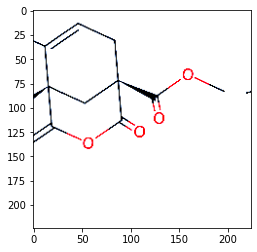

In [20]:
img = x['x'].cpu().numpy()
img = np.moveaxis(img, 0, 2)
plt.imshow(img)

# Model architecture

In [22]:
class Model(torch.nn.Module):
    def __init__(self, model_name='resnet34', pretrained=True):
        super(Model, self).__init__()
        self.cnn = timm.create_model(model_name, pretrained=pretrained)
        self.cnn.fc = nn.Linear(512, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output = self.relu(self.cnn(x))
        return output

# Training step 1:
- LR: 4e-4
- Image size: 224
- epochs: 12
- batch size: 1024

In [ ]:
!mkdir weights

n_epochs = 12
batch_size = 1024
LR = 4e-4

# Load training data loader
train_dataset = ImageDataset(train_mode=0, transforms=train_augs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Load validation data loader
valid_dataset = ImageDataset(train_mode=1, transforms=valid_augs)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# Create model
model = Model(model_name='resnet34', pretrained=True).to('cuda')
# Train using DP, 2x GPUs
model = nn.DataParallel(model)

# LR optimizer + scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0 = len(train_loader),
    T_mult = 1,
    eta_min = 1e-7,
    last_epoch= -1,
)

# Load validation Labels
VALID = train.loc[train.fold==1].reset_index(drop=True)

best_mae = 1.
scaler = torch.cuda.amp.GradScaler()
for epoch in range(n_epochs):
    
    with tqdm(train_loader) as pbar:
        for batch, data in enumerate(pbar):

            optimizer.zero_grad()

            # Casts operations to mixed precision
            with torch.cuda.amp.autocast():
                output = model(data['x'].to('cuda'))
                loss = criterion(data['y'].to('cuda'), output)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
            
            scheduler.step(batch)

            loss = loss.detach().cpu().numpy()
            lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix_str(f"{lr:.6f} train_loss: {loss:.4f}({best_mae:.4f})")

        # Run Validation loop
        YPRED = []
        with torch.no_grad():
            for data in tqdm(valid_loader):
                ypred = model(data['x'].to('cuda'))
                YPRED.append(ypred.cpu().numpy())
        YPRED = np.concatenate(YPRED)[:,0]
        VALID['pred'] = YPRED
        mae = (VALID['target'] - VALID['pred']).abs().mean()

        # Update best weight only
        if mae < best_mae:
            best_mae = mae
            print(f"New best: {epoch} {mae}")
            torch.save(model.module.state_dict(), f"weights/model_resnet34-{FOLD}-{batch_size}-{IMG_SIZE}-v1.pt")

# Training step 2:
- LR: 2e-4
- Image size: 224
- epochs: 12
- batch size: 1024

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR/2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0 = len(train_loader),
    T_mult = 1,
    eta_min = 1e-7,
    last_epoch= -1,
)

n_epochs = 12
for epoch in range(n_epochs):
    model.train()
    with tqdm(train_loader) as pbar:
        for batch, data in enumerate(pbar):

            optimizer.zero_grad()

            # Casts operations to mixed precision
            with torch.cuda.amp.autocast():
                output = model(data['x'].to('cuda'))
                loss = criterion(data['y'].to('cuda'), output)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
            
            scheduler.step(batch)

            loss = loss.detach().cpu().numpy()
            lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix_str(f"{lr:.6f} train_loss: {loss:.4f}({best_mae:.4f})")

    gc.collect()
    # Validation
    YPRED = []
    model.eval()
    with torch.no_grad():
        for data in tqdm(valid_loader):
            ypred = model(data['x'].to('cuda'))
            YPRED.append(ypred.cpu().numpy())
    YPRED = np.concatenate(YPRED)[:,0]
    VALID['pred'] = YPRED
    mae = (VALID['target'] - VALID['pred']).abs().mean()

    if mae < best_mae:
        best_mae = mae
        print(f"New best: {epoch} {mae}")
        torch.save(model.module.state_dict(), f"weights/model_resnet34-{FOLD}-{batch_size}-{IMG_SIZE}-v1.pt")
    gc.collect()

# Training step 3:  
- LR: 5e-5
- Image size: 288
- epochs: 6
- batch size: 512

In [ ]:
IMG_SIZE = 224+64

# Remove Vertical FLip from training
def get_augmentations():
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225) 
    
    train_augmentations = albu.Compose([
        albu.ShiftScaleRotate (shift_limit=0.05, scale_limit=0.05, rotate_limit=5, interpolation=1, border_mode=4, p=0.75),
        albu.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.90, 1.00), ratio=(0.95, 1.05), p=1.0),
        albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(0.5),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)
    
    valid_augmentations = albu.Compose([
        albu.Resize(IMG_SIZE, IMG_SIZE),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)   
    
    return train_augmentations, valid_augmentations

train_augs, valid_augs = get_augmentations()

n_epochs = 6
batch_size = 512

train_dataset = ImageDataset(train_mode=0, transforms=train_augs)
valid_dataset = ImageDataset(train_mode=1, transforms=valid_augs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

optimizer = torch.optim.Adam(model.parameters(), lr=LR/4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0 = len(train_loader),
    T_mult = 1,
    eta_min = 1e-7,
    last_epoch= -1,
)

best_mae = 1.0
criterion = nn.L1Loss()
scaler = torch.cuda.amp.GradScaler()
for epoch in range(n_epochs):
    model.train()
    with tqdm(train_loader) as pbar:
        for batch, data in enumerate(pbar):

            optimizer.zero_grad()

            # Casts operations to mixed precision
            with torch.cuda.amp.autocast():
                output = model(data['x'].to('cuda'))
                loss = criterion(data['y'].to('cuda'), output)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
            
            scheduler.step(batch)

            loss = loss.detach().cpu().numpy()
            lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix_str(f"{lr:.6f} train_loss: {loss:.4f}({best_mae:.4f})")

    gc.collect()
    # Validation
    YPRED = []
    model.eval()
    with torch.no_grad():
        for data in tqdm(valid_loader):
            ypred = model(data['x'].to('cuda'))
            YPRED.append(ypred.cpu().numpy())
    YPRED = np.concatenate(YPRED)[:,0]
    VALID['pred'] = YPRED
    mae = (VALID['target'] - VALID['pred']).abs().mean()

    if mae < best_mae:
        best_mae = mae
        print(f"New best: {epoch} {mae}")
        torch.save(model.module.state_dict(), f"weights/model_resnet34-{FOLD}-{batch_size}-{IMG_SIZE}-v1.pt")
    gc.collect()

# Training step 4:  
- LR: 2.5e-5
- Image size: 352
- epochs: 12
- batch size: 512

In [ ]:
IMG_SIZE = 224+64+64

# Remove shift scale rotate + Vertical flip 
def get_augmentations():
    
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225) 
    
    train_augmentations = albu.Compose([
        #albu.ShiftScaleRotate (shift_limit=0.05, scale_limit=0.05, rotate_limit=5, interpolation=1, border_mode=4, p=0.75),
        albu.RandomResizedCrop(IMG_SIZE, IMG_SIZE, scale=(0.90, 1.00), ratio=(0.95, 1.05), p=1.0),
        albu.HorizontalFlip(p=0.5),
        #albu.VerticalFlip(0.5),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)
    
    valid_augmentations = albu.Compose([
        albu.Resize(IMG_SIZE, IMG_SIZE),
        albu.Normalize(always_apply=True),        
        ToTensorV2(p=1.0)
    ], p=1.0)   
    
    return train_augmentations, valid_augmentations

train_augs, valid_augs = get_augmentations()

n_epochs = 12
batch_size = 512
LR = 2e-4

train_dataset = ImageDataset(train_mode=0, transforms=train_augs)
valid_dataset = ImageDataset(train_mode=1, transforms=valid_augs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

optimizer = torch.optim.Adam(model.parameters(), lr=LR/8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0 = len(train_loader),
    T_mult = 1,
    eta_min = 1e-7,
    last_epoch= -1,
)

best_mae = 1.0
criterion = nn.L1Loss()
scaler = torch.cuda.amp.GradScaler()
for epoch in range(n_epochs):
    model.train()
    with tqdm(train_loader) as pbar:
        for batch, data in enumerate(pbar):

            optimizer.zero_grad()

            # Casts operations to mixed precision
            with torch.cuda.amp.autocast():
                output = model(data['x'].to('cuda'))
                loss = criterion(data['y'].to('cuda'), output)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
            
            scheduler.step(batch)

            loss = loss.detach().cpu().numpy()
            lr = optimizer.param_groups[0]["lr"]
            pbar.set_postfix_str(f"{lr:.6f} train_loss: {loss:.4f}({best_mae:.4f})")

    gc.collect()
    # Validation
    YPRED = []
    model.eval()
    with torch.no_grad():
        for data in tqdm(valid_loader):
            ypred = model(data['x'].to('cuda'))
            YPRED.append(ypred.cpu().numpy())
    YPRED = np.concatenate(YPRED)[:,0]
    VALID['pred'] = YPRED
    mae = (VALID['target'] - VALID['pred']).abs().mean()

    if mae < best_mae:
        best_mae = mae
        print(f"New best: {epoch} {mae}")
        torch.save(model.module.state_dict(), f"weights/model_resnet34-{FOLD}-{batch_size}-{IMG_SIZE}-v1.pt")
    gc.collect()

# Training End

# Reload best epoch weights

In [ ]:
model = Model(model_name='resnet34', pretrained=True).to('cuda')
model.load_state_dict(torch.load(f"weights/model_resnet34-{FOLD}-512-352-v1.pt"))
model = nn.DataParallel(model)
model.eval()

In [46]:
IMG_SIZE = 224+64+64

valid_augmentations1 = albu.Compose([
    albu.Resize(IMG_SIZE, IMG_SIZE),
    albu.Normalize(always_apply=True),        
    ToTensorV2(p=1.0)
], p=1.0)   

batch_size = 512
valid_dataset = ImageDataset(train_mode=1, transforms=valid_augmentations1)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

test1_dataset = ImageDataset(train_mode=2, transforms=valid_augmentations1)
test1_loader = torch.utils.data.DataLoader(test1_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

test2_dataset = ImageDataset(train_mode=3, transforms=valid_augmentations1)
test2_loader = torch.utils.data.DataLoader(test2_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

(143840, 5)
(147037, 5)
(147432, 5)


In [47]:
YPRED = []
with torch.no_grad():
    for data in tqdm(valid_loader):
        ypred = model(data['x'].to('cuda'))
        YPRED.append(ypred.cpu().numpy())
yvalid = np.concatenate(YPRED)[:,0]
yvalid.shape

100%|██████████| 1124/1124 [05:08<00:00,  3.64it/s]


(143840,)

In [48]:
VALID['prediction'] = yvalid
(VALID['target'] - VALID['prediction']).abs().mean()

0.09870176142906208

In [49]:
YPRED = []
with torch.no_grad():
    for data in tqdm(test1_loader):
        ypred = model(data['x'].to('cuda'))
        YPRED.append(ypred.cpu().numpy())
ytest1 = np.concatenate(YPRED)[:,0]
ytest1.shape

100%|██████████| 1149/1149 [05:13<00:00,  3.67it/s]


(147037,)

In [50]:
YPRED = []
with torch.no_grad():
    for data in tqdm(test2_loader):
        ypred = model(data['x'].to('cuda'))
        YPRED.append(ypred.cpu().numpy())
ytest2 = np.concatenate(YPRED)[:,0]
ytest2.shape

100%|██████████| 1152/1152 [05:12<00:00,  3.69it/s]


(147432,)

In [61]:
train = pd.read_parquet('train.parquet')
train['path'] = '../images/' + train['id'].map(str) + '.png'

splits = torch.load('../new_split_dict.pt')
train['fold'] = 0
train.loc[train['id'].isin(splits[f'valid_{FOLD}']), 'fold'] = 1
train.loc[train['id'].isin(testdev_idx), 'fold'] = 2
train.loc[train['id'].isin(testchallenge_idx), 'fold'] = 3

VALID = train.loc[train['fold']==1].reset_index(drop=True)
TEST1 = train.loc[train['fold']==2].reset_index(drop=True)
TEST2 = train.loc[train['fold']==3].reset_index(drop=True)

VALID['prediction'] = yvalid
TEST1['prediction'] = ytest1
TEST2['prediction'] = ytest2

VALID.shape, TEST1.shape, TEST2.shape

((143840, 6), (147037, 6), (147432, 6))

# Validation MAE score

In [62]:
(VALID['target'] - VALID['prediction']).abs().mean()

0.09870176142906208

In [63]:
!mkdir predictions
!mkdir predictions/fold0
!mkdir predictions/fold1
!mkdir predictions/fold2
!mkdir predictions/fold3

np.save(f'predictions/fold{FOLD}/valid.npy', VALID['prediction'].values)
np.save(f'predictions/fold{FOLD}/devchallenge.npy', TEST1['prediction'].values)
np.save(f'predictions/fold{FOLD}/testchallenge.npy', TEST2['prediction'].values)

# Done!